## Getting started

In [2]:
# Import 
import os
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from itertools import permutations
import time
import pandas as pd
from joblib import dump, load
from pathlib import Path
import pyreadr

## sourceXray
from src.sourceXray_BJ import sourceXray, compute_C, solve_H_right_inverse
from src.utils import *

In [3]:
%load_ext autoreload
%autoreload 2

## Call data

In [4]:
obj = load("data/CB_10locs_complete_nonegpm25mpm1.joblib")
df = obj["df"]
Y = obj["Y"]
ys = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc', 'co', 'no', 'no2']
col_label = ["PM1", "PM2.5-PM1", "PM10-PM2.5", "TSP-PM10", "BC", "CO", "NO", "NO2"]
b = pd.to_numeric(df['bulldozer'], errors='coerce')
d = pd.to_numeric(df['downwind'],  errors='coerce')
df['bulldozerxdownwind'] = (b*d).astype('Int8')

In [5]:
df["date"].min()

Timestamp('2022-10-21 15:21:00+0000', tz='UTC')

In [6]:
# # peek at the data
# df.head(10) 

# # when CO is at its minimum
# df.loc[df['co'].idxmin()]

# # how many negatives?
# (df['bc'] < 0).sum()

In [7]:
# summary for numeric variables
print(df.describe().T) 
df[ys].quantile([0.15, 0.5, 0.85])

                       count        mean         std        min         25%  \
temp                451946.0   11.667073    8.124832      -13.3         6.0   
windspeed           451946.0    2.787886    2.481153        0.0        1.05   
humid               451946.0    55.19348   20.667266        6.3        38.8   
solar               450614.0  153.429006  246.293846        0.0         0.0   
pm1                 451946.0    8.372533    6.347737   0.089628     4.20757   
pm25mpm1            451946.0    0.922389    1.357977        0.0    0.280712   
pm10mpm25           451946.0   14.889989   36.579422        0.0    1.737535   
tspmpm10            451946.0   10.719751  148.813007        0.0         0.0   
bc                  451946.0    0.805216    1.292755 -10.711287     0.24856   
co                  451946.0  277.738407  178.683659   0.045119  195.355022   
no                  451946.0    8.226331    15.42531   0.000419    1.948819   
no2                 451946.0   13.644678    9.086583

,pm1,pm25mpm1,pm10mpm25,tspmpm10,bc,co,no,no2
0.15,3.171208,0.195416,0.801946,0.000000,0.106513,179.858042,1.655960,4.968956
0.50,6.956463,0.550571,6.467885,0.000000,0.564628,231.097617,3.229103,11.113241
0.85,13.705409,1.566025,26.131649,14.190067,1.483417,373.252646,11.886377,24.472340


In [20]:
per_minute_bulldozer = (
    df.drop_duplicates(subset='date_local') # at the same date_local, bulldozer is repeated for locations
      .set_index('date_local')['bulldozer']
)

avg_bulldozer_minutes_per_day = (
    per_minute_bulldozer.eq(1)                           # True when active
      .groupby(per_minute_bulldozer.index.normalize())   # group by day
      .sum()                                             # minutes per day
      .mean()                                            # average over days
)

print(avg_bulldozer_minutes_per_day)
print(avg_bulldozer_minutes_per_day/60/24)

avg_downwind_minutes_per_day_by_loc = (
    df['downwind'].eq(1)
      .groupby([df['location'], df['date_local'].dt.normalize()])  # group by location & day
      .sum()                                                       # minutes per day per location
      .groupby(level='location')                                   # now group over locations
      .mean()                                                      # average over days within each location
)

print(avg_downwind_minutes_per_day_by_loc)
print(avg_downwind_minutes_per_day_by_loc/60/24)

460.0403587443946
0.31947247135027407
location
1    230.443946
2    194.659193
5     82.977578
8    128.161435
Name: downwind, dtype: float64
location
1    0.160031
2    0.135180
5    0.057623
8    0.089001
Name: downwind, dtype: float64


/var/folders/n2/whtt7knd3ld2z521r1w6wvyh0000gn/T/ipykernel_75406/2565804951.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([df['location'], df['date_local'].dt.normalize()])  # group by location & day
/var/folders/n2/whtt7knd3ld2z521r1w6wvyh0000gn/T/ipykernel_75406/2565804951.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level='location')                                   # now group over locations


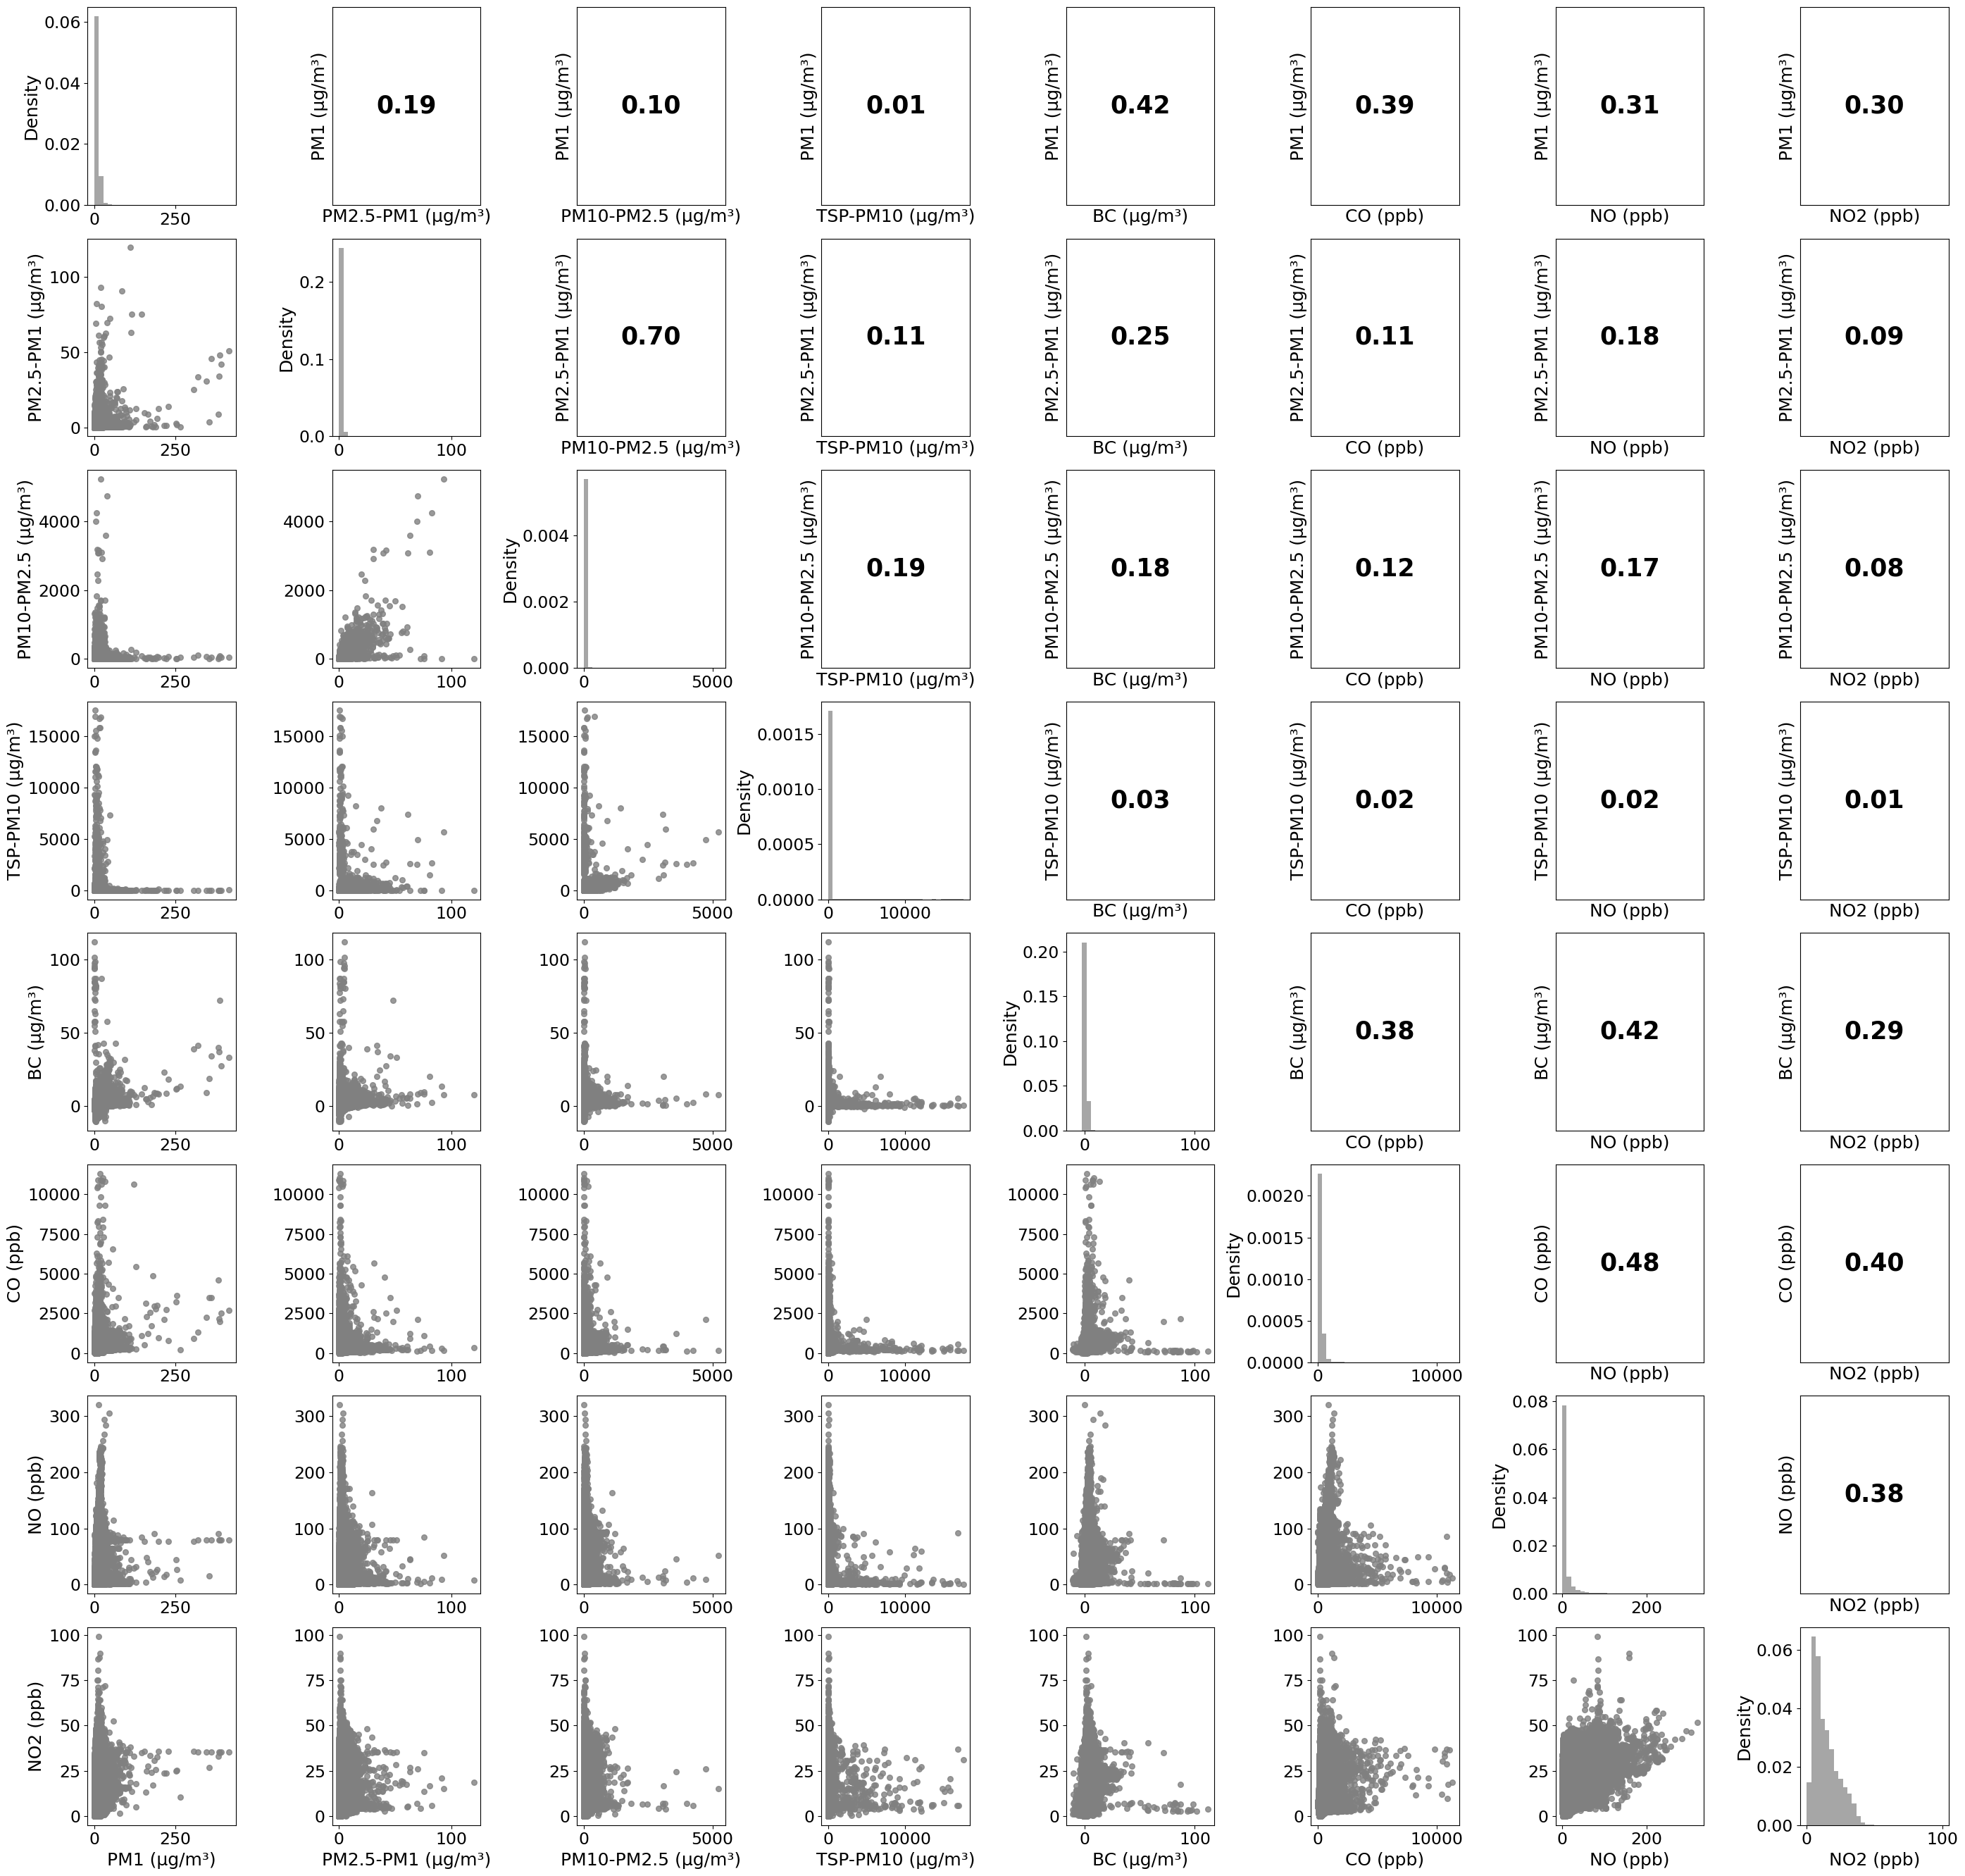

In [11]:
col_label_mu=["PM1 (µg/m³)", "PM2.5-PM1 (µg/m³)", "PM10-PM2.5 (µg/m³)", "TSP-PM10 (µg/m³)", 
              "BC (µg/m³)", "CO (ppb)", "NO (ppb)", "NO2 (ppb)"]
plot_full_scatter_matrix(df[ys],
                         alpha=0.8, 
                         labels=col_label_mu,
                         draw_diagonal=True,
                         title=None, 
                         quantile=None,
                         convexhull=False,
                         draw_upper_corr=True,
                         corr_fmt="{:.2f}",
                         corr_fontsize=25,          
                         # savepath="results/CB/figure/CB_nonegpm25mpm1_Y_Scatter_wcorr.png"
)

## Linear regressions

Similar setup as https://link.springer.com/article/10.1007/s11869-025-01773-w

They droped interaction term from eq (1); bull + downwind_wide + temp + no + ws + am_pm + solar_radiation + location, which is not documented well in the manuscript. 

Values are different because 
1. PM2.5, PM10, TSP (Boni) vs. PM2.5-PM1, PM10-PM2.5, TSP-PM10 (Bora)
2. Incomplete data (Boni) vs. complete data (Bora)
3. No interaction (Boni) vs. interaction (Bora)

Covariates of primary interest: Bulldozer, Downwind, Interaction

Goal:
1. See if we observe similar direction and magnitude for individual pollutants
2. Examine precision of main and interaction effects for the NMF sources

In [12]:
# PMs
ys_pms = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc']
formula_pms = (
    "bulldozer*downwind + temp + no + windspeed + am + solar + location"
)
results_pms = run_multireg(df, formula_pms, ys_pms, alpha = 0.05, add_main_plus=True) # bulldozer + downwind + bulldozer:downwind
# Gas
ys_gas = ['co', 'no', 'no2']
formula_gas = (
    "bulldozer*downwind + temp + windspeed + am + solar + location"
)
results_gas = run_multireg(df, formula_gas, ys_gas, alpha = 0.05, add_main_plus=True)
results_df = pd.concat([results_pms, results_gas], ignore_index=True)

In [15]:
# # quick look
# print(results_df.to_string())

# # access a specific term quickly, e.g., interaction:
# print(results_df.query("term == 'bulldozer[T.1]'"))
# print(results_df.query("term in ['bulldozer[T.1]', 'downwind[T.1]'] and response == 'tspmpm10'").to_string(float_format="{:.3f}".format))

In [18]:
# create a large df 
results_all_df = results_df

# Pretty labels
def pretty_y(t):
    mapping = {
        'pm1': "PM1",
        'pm25mpm1': "PM2.5-PM1", 
        'pm10mpm25': "PM10-PM2.5", 
        'tspmpm10': "TSP-PM10", 
        'bc': "BC", 
        'co': "CO", 
        'no': "NO", 
        'no2': "NO2"
    }
    return mapping.get(t, t)

def pretty_x(t):
    mapping = {
        "main_plus_interaction": "Bulldozer=1 x Downwind=1",
        "bulldozer[T.1]:downwind[T.1]": "Interaction",
        "bulldozer[T.1]": "Bulldozer=1",
        "downwind[T.1]":  "Downwind=1",
        "location[T.2]": "Location=2", 
        "location[T.5]": "Location=5", 
        "location[T.8]": "Location=8", 
        "am[T.1]": "AM=1",
        "stable[T.1]": "Atmospheric stability=1",
        "temp": "Temperature",
        "windspeed": "Wind speed",
        "humid": "Relative humidity",
        "solar": "Solar radiation", 
        'no': "NO", 
    }
    return mapping.get(t, t)

def pretty_type(t):
    mapping = {
        0: "Pooled",
        1:  "Loc 1",
        2: "Loc 2", 
        5: "Loc 5", 
        8: "Loc 8", 
        11: "Supersite",
    }
    return mapping.get(t, t)
    
results_all_df["term"] = results_all_df["term"].map(pretty_x)
results_all_df["response"] = results_all_df["response"].map(pretty_y)

In [21]:
keep_terms = ["Bulldozer=1", "Downwind=1", "Bulldozer=1 x Downwind=1"]

results_subset_df = results_all_df[
    results_all_df["term"].isin(keep_terms)
].copy()

results_subset_df['label_y'] = results_subset_df['response']
results_subset_df['label_x'] = results_subset_df['term']
results_subset_df['lo'] = results_subset_df['ci_low']
results_subset_df['hi'] = results_subset_df['ci_high']

/Users/borajin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


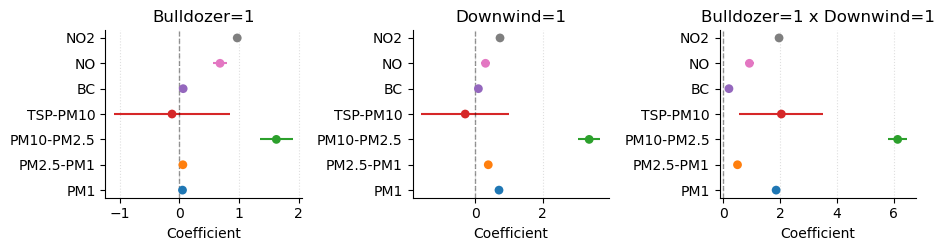

In [22]:
results_subset_df2 = results_subset_df.query("response != 'CO'")
plot_coefficients_by_response(
    results_subset_df2, 
    shape_map = {"PM1":"o", "PM2.5-PM1":"o", "PM10-PM2.5":"o", "TSP-PM10":"o", "BC":"o", "CO":"o", "NO":"o", "NO2":"o"}, 
    color_map = {"PM1":"tab:blue", "PM2.5-PM1":"tab:orange", "PM10-PM2.5":"tab:green", "TSP-PM10":"tab:red", "BC":"tab:purple", 
                 "CO":"tab:brown", "NO":"tab:pink", "NO2":"tab:grey"},  
)

## Density of pollutants by covariates

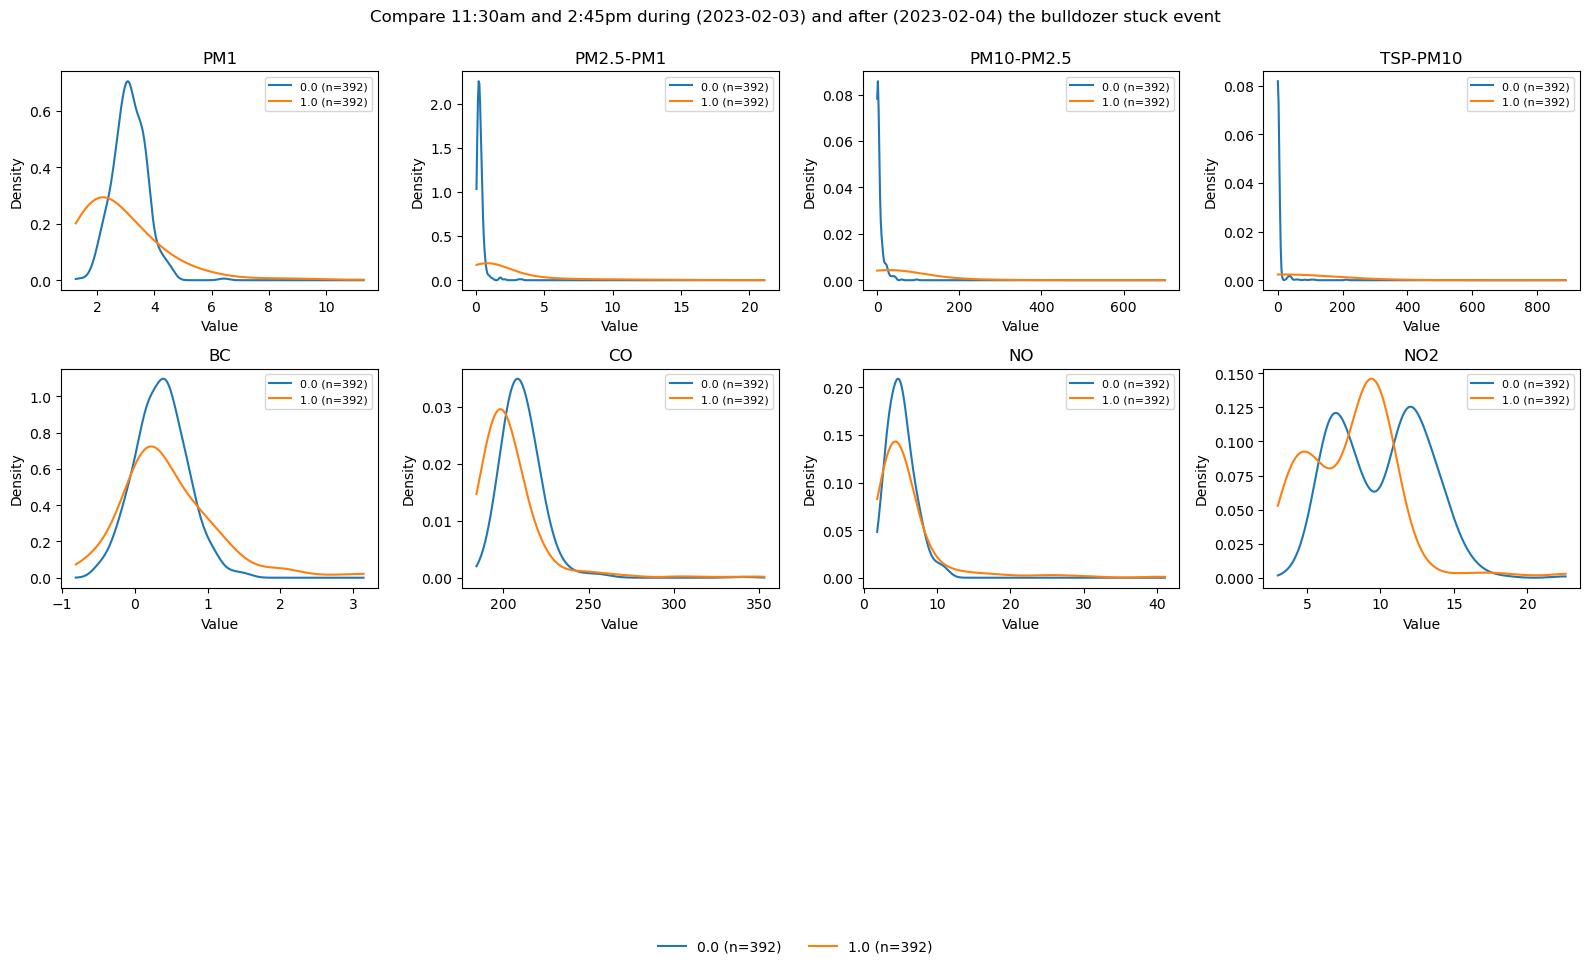

In [23]:
# Define the two windows (inclusive)
win1_start = pd.Timestamp('2023-02-04 11:30', tz='America/New_York')
win1_end   = pd.Timestamp('2023-02-04 14:45', tz='America/New_York')

win2_start = pd.Timestamp('2023-02-03 11:30', tz='America/New_York')
win2_end   = pd.Timestamp('2023-02-03 14:45', tz='America/New_York')

in_win1 = (df['date_local'] >= win1_start) & (df['date_local'] <= win1_end)
in_win2 = (df['date_local'] >= win2_start) & (df['date_local'] <= win2_end)

# Build covariate: 1 for 2023-02-03 window, 0 for 2023-02-04 window, NaN otherwise
cov_03_vs_04 = pd.Series(np.where(in_win2, 1, np.where(in_win1, 0, np.nan)), index=df.index)

plot_W_by_covariate(
    df.loc[:,ys],
    covariate=cov_03_vs_04,
    include_nan=False,                 # drops rows outside the two windows
    xlabel="Value",
    panel_title=col_label,
    suptitle="Compare 11:30am and 2:45pm during (2023-02-03) and after (2023-02-04) the bulldozer stuck event"
)

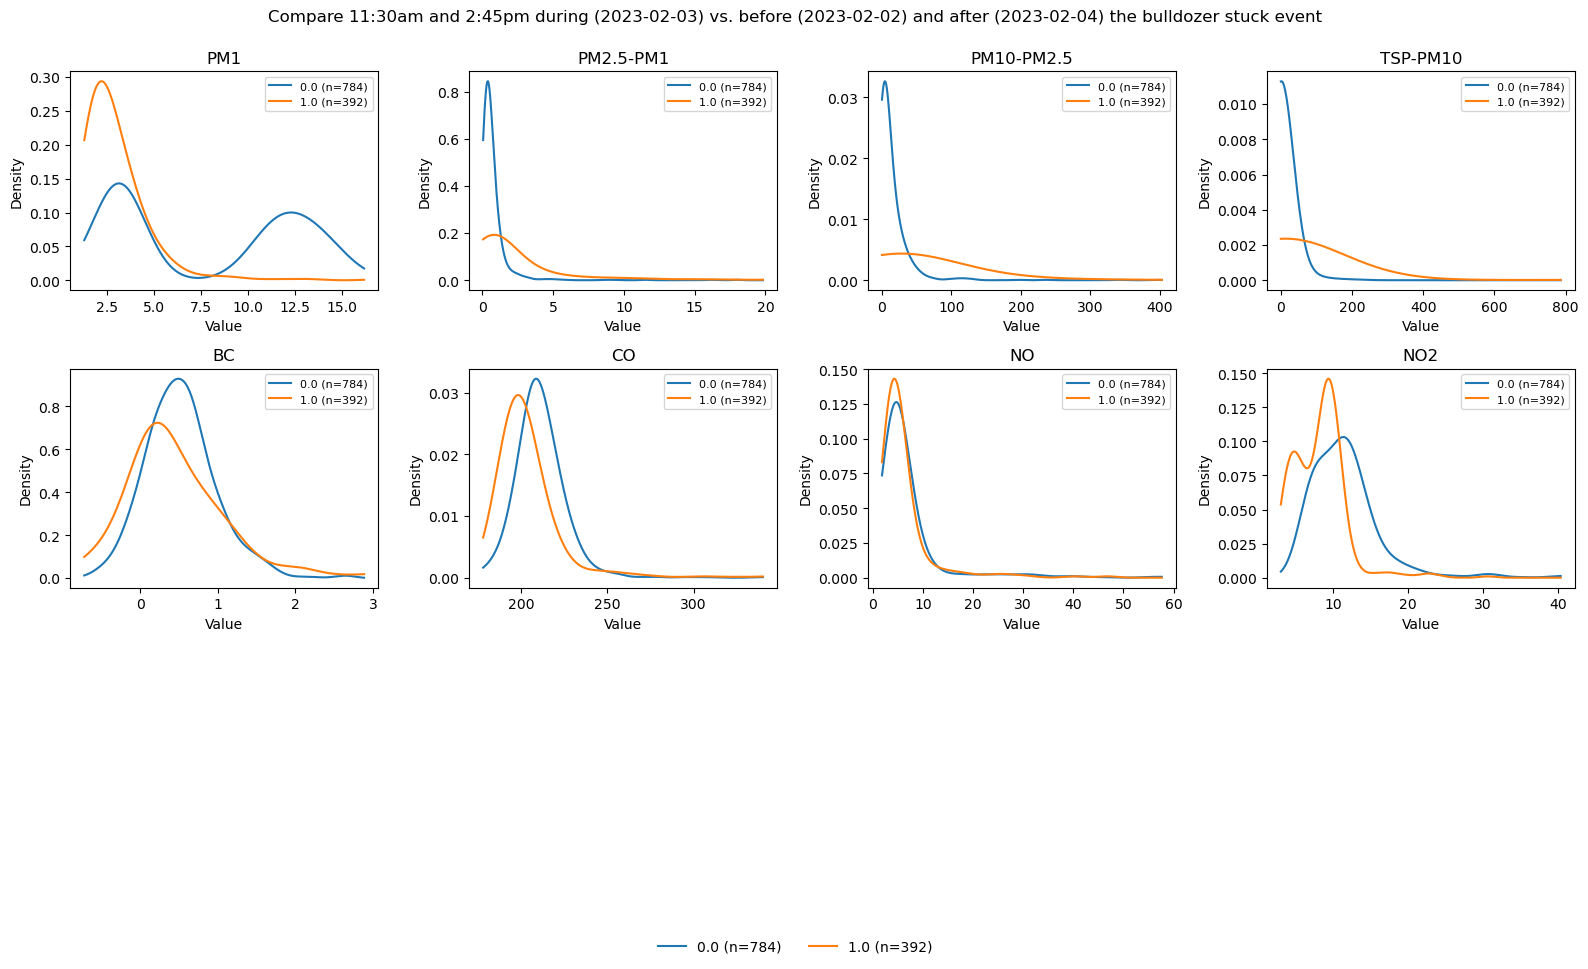

In [24]:
# Define the two windows (inclusive)
win3_start = pd.Timestamp('2023-02-02 11:30', tz='America/New_York')
win3_end   = pd.Timestamp('2023-02-02 14:45', tz='America/New_York')

in_win13 = (
    df['date_local'].between(win1_start, win1_end, inclusive='both')
    | df['date_local'].between(win3_start, win3_end, inclusive='both')
)
in_win2 = (df['date_local'] >= win2_start) & (df['date_local'] <= win2_end)

# Build covariate: 1 for 2023-02-03 window, 0 for 2023-02-04 window, NaN otherwise
cov_03_vs_0204 = pd.Series(np.where(in_win2, 1, np.where(in_win13, 0, np.nan)), index=df.index)

plot_W_by_covariate(
    df.loc[:,ys],
    covariate=cov_03_vs_0204,
    include_nan=False,                 # drops rows outside the two windows
    xlabel="Value",
    panel_title=col_label,
    suptitle="Compare 11:30am and 2:45pm during (2023-02-03) vs. before (2023-02-02) and after (2023-02-04) the bulldozer stuck event"
)

## Two-sample tests for equality of the entire distribution

In [25]:
def q(p):
    def f(s): return s.quantile(p)
    f.__name__ = f"q{int(p*100)}"   # nice names: q80, q90, q95
    return f

from scipy.stats import anderson_ksamp

def ad_k_sample_by_group(
    df,
    ys,
    group_col='cov_03_vs_04',
    groups=(0, 1),          # which groups to compare
    include_nan=False,      # treat NaN as its own group
    min_n=5                 # SciPy requires >= 5 obs per sample
):
    ys = list(ys)
    if include_nan and (np.nan not in groups):
        groups = tuple(list(groups) + [np.nan])

    rows = []
    for y in ys:
        samples, n_each, used_groups = [], [], []
        for g in groups:
            sel = df[group_col].isna() if pd.isna(g) else df[group_col].eq(g)
            s = df.loc[sel, y].dropna().to_numpy()
            if s.size >= min_n:
                samples.append(s)
                n_each.append(int(s.size))
                used_groups.append('NA' if pd.isna(g) else g)

        if len(samples) >= 2:
            try:
                res = anderson_ksamp(samples)  # midrank=True by default
                rows.append({
                    'Y': y,
                    'k': len(samples),
                    'groups': tuple(used_groups),
                    'n_each': tuple(n_each),
                    'statistic': float(res.statistic),
                    'significance_level': float(res.significance_level),  # approx p-value
                    'critical_values': tuple(res.critical_values),
                })
            except Exception as e:
                rows.append({
                    'Y': y, 'k': len(samples), 'groups': tuple(used_groups),
                    'n_each': tuple(n_each), 'error': str(e)
                })
        else:
            rows.append({
                'Y': y,
                'k': len(samples),
                'groups': tuple(used_groups),
                'n_each': tuple(n_each),
                'error': f'Need ≥2 groups with ≥{min_n} non-missing values.'
            })

    return pd.DataFrame(rows)

from scipy.stats import mannwhitneyu, ks_2samp

def one_sided_by_group(df, ys, group_col='cov_03_vs_04', g0=0, g1=1,
                       alternative='greater', test='mw', min_n=5):
    """
    alternative='greater' means: distribution of group g1 > group g0
    test: 'mw' (Mann–Whitney) or 'ks' (Kolmogorov–Smirnov)
    """
    rows = []
    for y in ys:
        x0 = df.loc[df[group_col].eq(g0), y].dropna().to_numpy()
        x1 = df.loc[df[group_col].eq(g1), y].dropna().to_numpy()
        if len(x0) < min_n or len(x1) < min_n:
            rows.append({'Y': y, 'n0': len(x0), 'n1': len(x1),
                         'method': test.upper(), 'alternative': alternative,
                         'error': f'Need ≥{min_n} per group'})
            continue

        if test == 'mw':
            # order matters: x1 vs x0 so 'greater' tests x1 > x0
            res = mannwhitneyu(x1, x0, alternative=alternative)
            U = float(res.statistic)
            m, n = len(x1), len(x0)
            p_superiority = U / (m * n)              # P(X1 > X0) + 0.5 P(tie)
            cliffs_delta = 2 * p_superiority - 1     # effect size in [-1, 1]
            rows.append({'Y': y, 'n0': n, 'n1': m, 'method': 'Mann–Whitney U',
                         'alternative': alternative, 'statistic': U,
                         'pvalue': float(res.pvalue),
                         'p_superiority': p_superiority,
                         'cliffs_delta': cliffs_delta})
        else:
            res = ks_2samp(x0, x1, alternative=alternative, mode='auto') # x0, x1 position reversed because "Suppose that the first sample were drawn from a normal distribution shifted toward greater values. In this case, the cumulative density function (CDF) of the underlying distribution tends to be less than the CDF underlying the second sample. Therefore, we would expect the null hypothesis to be rejected with alternative='less'"
            # F_0 >= F_1: x0 is stochastically smaller (shifted left; its CDF is higher)
            rows.append({'Y': y, 'n0': len(x0), 'n1': len(x1), 'method': 'KS',
                         'alternative': alternative, 'statistic': float(res.statistic),
                         'pvalue': float(res.pvalue)})
    return pd.DataFrame(rows)


In [26]:
df['cov_03_vs_0204'] = cov_03_vs_0204
g = df.groupby('cov_03_vs_0204', observed=True)[ys]
summary = g.agg(['count', 'mean', 'median', 'std', q(.80), q(.85), q(.90), q(.95), 'max'])
summary.columns.names = ['variable', 'stat']   # nicer column levels

print(summary.T.to_string(float_format="{:.3f}".format)) # baseline group summary stats closer to "the rest" 

cov_03_vs_0204        0.0      1.0
variable  stat                    
pm1       count   784.000  392.000
          mean      7.835    3.022
          median    7.860    2.441
          std       4.841    2.813
          q80      12.860    3.755
          q85      13.345    4.102
          q90      13.897    4.532
          q95      14.470    5.738
          max      19.731   46.400
pm25mpm1  count   784.000  392.000
          mean      0.702    2.533
          median    0.439    0.782
          std       1.205    5.012
          q80       0.879    3.122
          q85       1.035    4.114
          q90       1.256    6.477
          q95       1.916   10.633
          max      17.984   61.349
pm10mpm25 count   784.000  392.000
          mean     13.987   68.048
          median    4.982   22.931
          std      31.422  262.682
          q80      20.625   61.959
          q85      25.488   84.842
          q90      31.766  127.287
          q95      45.446  176.825
          max     45

In [27]:
# Anderson–Darling test, only two-sided
# H0: F0 = F1 vs. H1: F0 != F1 (x0 ~ F0, x1 ~ F1)
res_01 = ad_k_sample_by_group(df, ys, group_col='cov_03_vs_0204', groups=(0,1), include_nan=False)
# Mann-Whitney U test
# H0: F0 = F1 vs. H1: F0 < F1 
res_mw = one_sided_by_group(df, ys, group_col='cov_03_vs_0204', g0=0, g1=1,
                            alternative='greater', test='mw') # great for directional, overall stochastic dominance, but it effectively averages rank differences across the whole distribution—tail-only shifts can get diluted.
# Kolmogorov-Smirnov test
# H0: CDF0 <= CDF1 vs. H1: CDF0 > CDF1 (x0 is stochastically smaller than x1)
res_ks = one_sided_by_group(df, ys, group_col='cov_03_vs_0204', g0=0, g1=1,
                            alternative='greater', test='ks') # maximizes the largest CDF gap at some threshold; if the difference lives in the upper (or lower) tail, the max often occurs there, so KS tends to pick it up better than MWU.

/var/folders/n2/whtt7knd3ld2z521r1w6wvyh0000gn/T/ipykernel_40711/3124862476.py:33: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  res = anderson_ksamp(samples)  # midrank=True by default
/Users/borajin/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [28]:
print(res_01.sort_values('significance_level').to_string(float_format="{:.3f}".format))

           Y  k  groups      n_each  statistic  significance_level                                                               critical_values
0        pm1  2  (0, 1)  (784, 392)    233.963               0.001  (0.32500000000000007, 1.226, 1.9609999999999999, 2.718, 3.752, 4.592, 6.546)
1   pm25mpm1  2  (0, 1)  (784, 392)     86.786               0.001  (0.32500000000000007, 1.226, 1.9609999999999999, 2.718, 3.752, 4.592, 6.546)
2  pm10mpm25  2  (0, 1)  (784, 392)    129.127               0.001  (0.32500000000000007, 1.226, 1.9609999999999999, 2.718, 3.752, 4.592, 6.546)
3   tspmpm10  2  (0, 1)  (784, 392)     54.194               0.001  (0.32500000000000007, 1.226, 1.9609999999999999, 2.718, 3.752, 4.592, 6.546)
4         bc  2  (0, 1)  (784, 392)     17.731               0.001  (0.32500000000000007, 1.226, 1.9609999999999999, 2.718, 3.752, 4.592, 6.546)
5         co  2  (0, 1)  (784, 392)     98.425               0.001  (0.32500000000000007, 1.226, 1.9609999999999999, 2.718, 3.752,

In [29]:
print(res_mw.sort_values('pvalue').to_string(float_format="{:.3f}".format))

           Y   n0   n1          method alternative  statistic  pvalue  p_superiority  cliffs_delta
2  pm10mpm25  784  392  Mann–Whitney U     greater 230055.000   0.000          0.749         0.497
1   pm25mpm1  784  392  Mann–Whitney U     greater 214020.000   0.000          0.696         0.393
3   tspmpm10  784  392  Mann–Whitney U     greater 176734.000   0.000          0.575         0.150
6         no  784  392  Mann–Whitney U     greater 140421.000   0.992          0.457        -0.086
4         bc  784  392  Mann–Whitney U     greater 134034.000   1.000          0.436        -0.128
0        pm1  784  392  Mann–Whitney U     greater  52865.000   1.000          0.172        -0.656
5         co  784  392  Mann–Whitney U     greater  88992.000   1.000          0.290        -0.421
7        no2  784  392  Mann–Whitney U     greater  76241.000   1.000          0.248        -0.504


In [30]:
print(res_ks.sort_values('pvalue').to_string(float_format="{:.3f}".format))

           Y   n0   n1 method alternative  statistic  pvalue
2  pm10mpm25  784  392     KS     greater      0.355   0.000
1   pm25mpm1  784  392     KS     greater      0.288   0.000
3   tspmpm10  784  392     KS     greater      0.176   0.000
4         bc  784  392     KS     greater      0.057   0.170
6         no  784  392     KS     greater      0.046   0.319
5         co  784  392     KS     greater      0.031   0.596
0        pm1  784  392     KS     greater      0.003   0.994
7        no2  784  392     KS     greater      0.000   1.000


In [31]:
g = df.groupby(['location', 'cov_03_vs_0204'], observed=True)[ys]
summary = g.agg(['count', 'mean', 'median', 'std', q(.80), q(.85), q(.90), q(.95), 'max'])
summary.columns.names = ['variable', 'stat']   # nicer column levels

print(summary.T.to_string(float_format="{:.3f}".format)) # baseline group summary stats closer to "the rest" 

location                1                8        
cov_03_vs_0204        0.0      1.0     0.0     1.0
variable  stat                                    
pm1       count   392.000  196.000 392.000 196.000
          mean      7.823    3.762   7.846   2.283
          median    7.860    3.013   6.981   2.118
          std       4.937    3.777   4.749   0.711
          q80      12.861    4.532  12.849   2.885
          q85      13.412    5.315  13.319   3.078
          q90      14.055    5.747  13.711   3.376
          q95      14.683    7.898  14.326   3.626
          max      19.731   46.400  16.077   4.318
pm25mpm1  count   392.000  196.000 392.000 196.000
          mean      0.962    4.610   0.443   0.457
          median    0.532    2.431   0.373   0.421
          std       1.638    6.452   0.295   0.247
          q80       1.221    6.492   0.635   0.607
          q85       1.464    8.258   0.757   0.676
          q90       1.917   10.634   0.882   0.749
          q95       2.725   15.

In [32]:
df1=df.loc[df['location']==1]
# Anderson–Darling test, only two-sided
# H0: F0 = F1 vs. H1: F0 != F1 (x0 ~ F0, x1 ~ F1)
res_01 = ad_k_sample_by_group(df1, ys, group_col='cov_03_vs_0204', groups=(0,1), include_nan=False)
# Mann-Whitney U test
# H0: F0 = F1 vs. H1: F0 < F1 
res_mw = one_sided_by_group(df1, ys, group_col='cov_03_vs_0204', g0=0, g1=1,
                            alternative='greater', test='mw') # great for directional, overall stochastic dominance, but it effectively averages rank differences across the whole distribution—tail-only shifts can get diluted.
# Kolmogorov-Smirnov test
# H0: CDF0 <= CDF1 vs. H1: CDF0 > CDF1 (x0 is stochastically smaller than x1)
res_ks = one_sided_by_group(df1, ys, group_col='cov_03_vs_0204', g0=0, g1=1,
                            alternative='greater', test='ks') # maximizes the largest CDF gap at some threshold; if the difference lives in the upper (or lower) tail, the max often occurs there, so KS tends to pick it up better than MWU.

/var/folders/n2/whtt7knd3ld2z521r1w6wvyh0000gn/T/ipykernel_40711/3124862476.py:33: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  res = anderson_ksamp(samples)  # midrank=True by default


In [33]:
print(res_mw.sort_values('pvalue').to_string(float_format="{:.3f}".format))

           Y   n0   n1          method alternative  statistic  pvalue  p_superiority  cliffs_delta
1   pm25mpm1  392  196  Mann–Whitney U     greater  67454.000   0.000          0.878         0.756
2  pm10mpm25  392  196  Mann–Whitney U     greater  65190.000   0.000          0.848         0.697
3   tspmpm10  392  196  Mann–Whitney U     greater  48446.500   0.000          0.631         0.261
4         bc  392  196  Mann–Whitney U     greater  43417.000   0.005          0.565         0.130
5         co  392  196  Mann–Whitney U     greater  41002.000   0.092          0.534         0.067
6         no  392  196  Mann–Whitney U     greater  40752.000   0.115          0.530         0.061
0        pm1  392  196  Mann–Whitney U     greater  20163.000   1.000          0.262        -0.475
7        no2  392  196  Mann–Whitney U     greater  13618.000   1.000          0.177        -0.646


In [34]:
print(res_ks.sort_values('pvalue').to_string(float_format="{:.3f}".format))

           Y   n0   n1 method alternative  statistic  pvalue
1   pm25mpm1  392  196     KS     greater      0.597   0.000
2  pm10mpm25  392  196     KS     greater      0.551   0.000
3   tspmpm10  392  196     KS     greater      0.288   0.000
6         no  392  196     KS     greater      0.168   0.001
4         bc  392  196     KS     greater      0.161   0.001
5         co  392  196     KS     greater      0.125   0.016
0        pm1  392  196     KS     greater      0.005   0.992
7        no2  392  196     KS     greater      0.000   1.000


In [35]:
df8=df.loc[df['location']==8]
# Anderson–Darling test, only two-sided
# H0: F0 = F1 vs. H1: F0 != F1 (x0 ~ F0, x1 ~ F1)
res_01 = ad_k_sample_by_group(df8, ys, group_col='cov_03_vs_0204', groups=(0,1), include_nan=False)
# Mann-Whitney U test
# H0: F0 = F1 vs. H1: F0 < F1 
res_mw = one_sided_by_group(df8, ys, group_col='cov_03_vs_0204', g0=0, g1=1,
                            alternative='greater', test='mw') # great for directional, overall stochastic dominance, but it effectively averages rank differences across the whole distribution—tail-only shifts can get diluted.
# Kolmogorov-Smirnov test
# H0: CDF0 <= CDF1 vs. H1: CDF0 > CDF1 (x0 is stochastically smaller than x1)
res_ks = one_sided_by_group(df8, ys, group_col='cov_03_vs_0204', g0=0, g1=1,
                            alternative='greater', test='ks') # maximizes the largest CDF gap at some threshold; if the difference lives in the upper (or lower) tail, the max often occurs there, so KS tends to pick it up better than MWU.

/var/folders/n2/whtt7knd3ld2z521r1w6wvyh0000gn/T/ipykernel_40711/3124862476.py:33: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  res = anderson_ksamp(samples)  # midrank=True by default


In [36]:
print(res_mw.sort_values('pvalue').to_string(float_format="{:.3f}".format))

           Y   n0   n1          method alternative  statistic  pvalue  p_superiority  cliffs_delta
2  pm10mpm25  392  196  Mann–Whitney U     greater  51542.000   0.000          0.671         0.342
1   pm25mpm1  392  196  Mann–Whitney U     greater  42095.000   0.029          0.548         0.096
3   tspmpm10  392  196  Mann–Whitney U     greater  40010.000   0.046          0.521         0.041
6         no  392  196  Mann–Whitney U     greater  28510.500   1.000          0.371        -0.258
4         bc  392  196  Mann–Whitney U     greater  23162.000   1.000          0.301        -0.397
0        pm1  392  196  Mann–Whitney U     greater   5586.000   1.000          0.073        -0.855
5         co  392  196  Mann–Whitney U     greater   3797.000   1.000          0.049        -0.901
7        no2  392  196  Mann–Whitney U     greater  10566.000   1.000          0.138        -0.725


In [37]:
print(res_ks.sort_values('pvalue').to_string(float_format="{:.3f}".format))

           Y   n0   n1 method alternative  statistic  pvalue
2  pm10mpm25  392  196     KS     greater      0.273   0.000
1   pm25mpm1  392  196     KS     greater      0.148   0.003
3   tspmpm10  392  196     KS     greater      0.071   0.260
6         no  392  196     KS     greater      0.061   0.371
7        no2  392  196     KS     greater      0.013   0.956
0        pm1  392  196     KS     greater      0.000   1.000
4         bc  392  196     KS     greater      0.000   1.000
5         co  392  196     KS     greater      0.000   1.000


## Timeseries around bulldozer stuck accident (2023-02-03 11:30 -- 14:45)

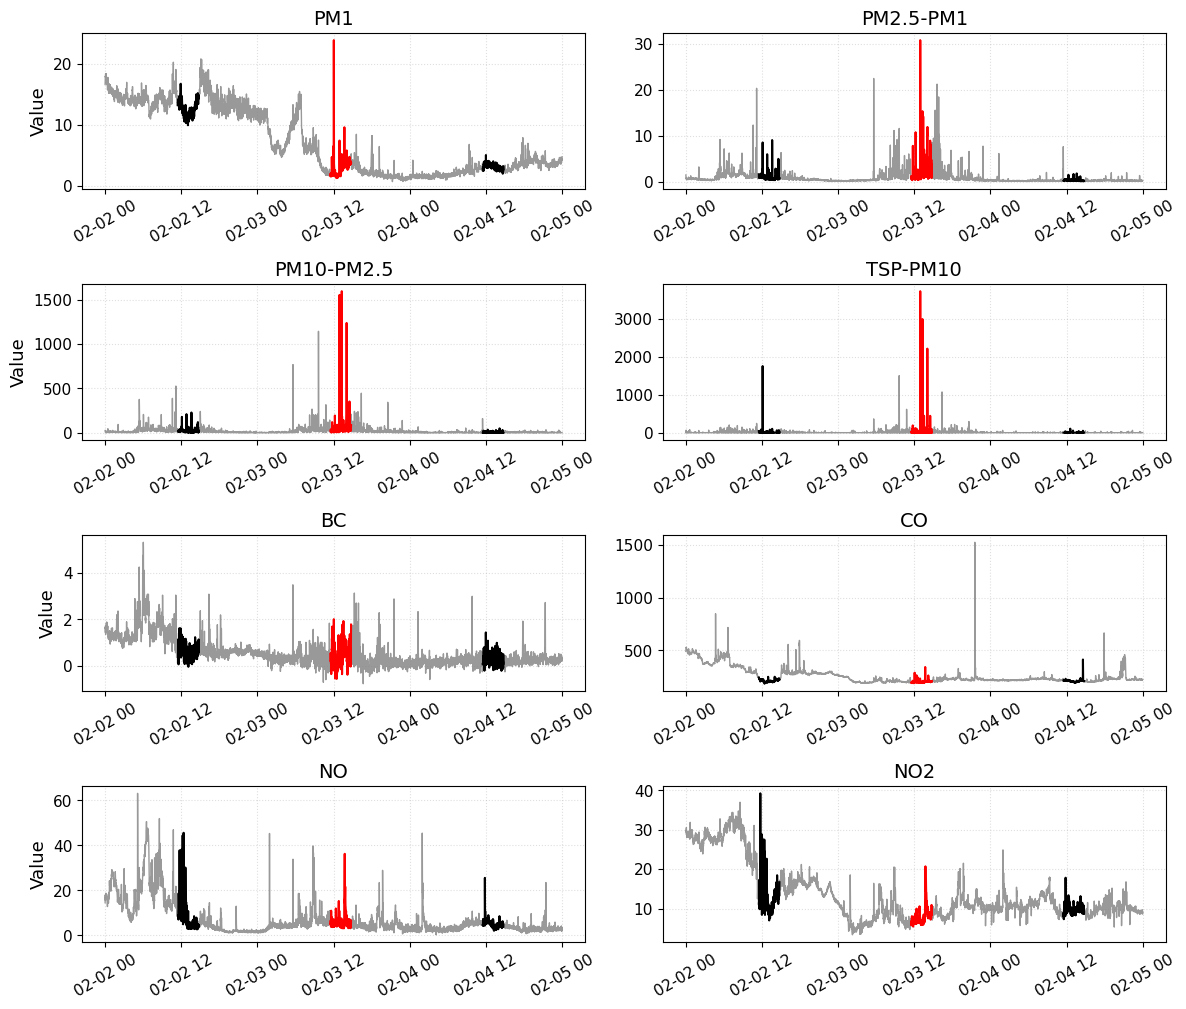

In [38]:
acc_start = win2_start
acc_end = win2_end

start = pd.Timestamp('2023-02-02 00:00:00', tz='America/New_York')
end   = pd.Timestamp('2023-02-04 23:59:00', tz='America/New_York')

m = (df['date_local'] >= start) & (df['date_local'] <= end)
df_subset = df.loc[m].copy()
df_subset_mean = (
    df_subset
      .pivot_table(index=['date_local', 'bulldozer'], values=ys, aggfunc='mean', observed=True)
      .sort_index()
      .reset_index()
)

plot_timeseries_facets(df_subset_mean, 
                       cols=ys,
                       time_col='date_local',
                       ncols=2,
                       figsize_per_panel=(6, 2.6), # (width, height) per panel
                       sharex=False,
                       sharey=False,
                       lw=1,
                       alpha=0.8,
                       xrotation=30,
                       title=None,
                       panel_title=col_label, 
                       highlight=[(acc_start, acc_end), (win1_start, win1_end), (win3_start, win3_end)], 
                       highlight_color=["red", "black", "black"])

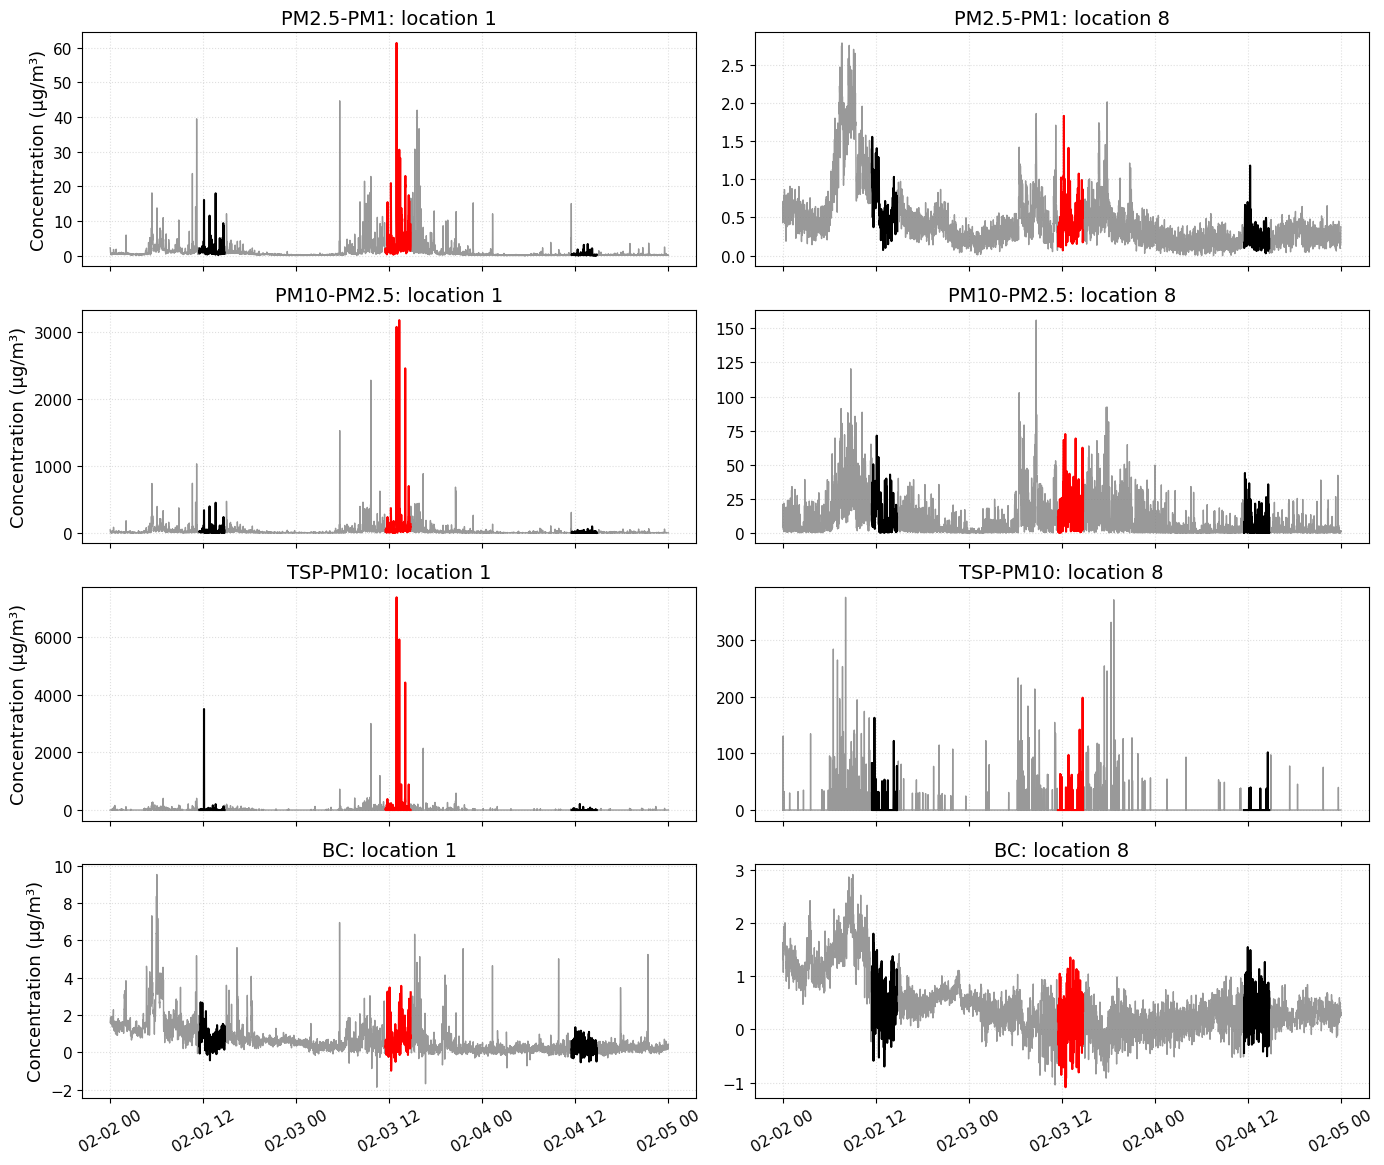

In [39]:
plot_timeseries_facets(df_subset, 
                       cols=ys[1:5],
                       time_col='date_local',
                       ncols=2,
                       figsize_per_panel=(7, 3), # (width, height) per panel
                       sharex=True,
                       sharey=False,
                       lw=1,
                       alpha=0.8,
                       xrotation=30,
                       ylabel="Concentration (µg/m³)",
                       panel_title=col_label[1:5], 
                       covariate="location", 
                       label_map={1:"location 1", 8:"location 8"},
                       facet_by_group=True,
                       highlight=[(acc_start, acc_end), (win1_start, win1_end), (win3_start, win3_end)], 
                       highlight_color=["red", "black", "black"], 
                       # savepath="results/CB/figure/CB_nonegpm25mpm1_bulldozerstuck_timeseries_pm25tobc_byloc.pdf"
                      )

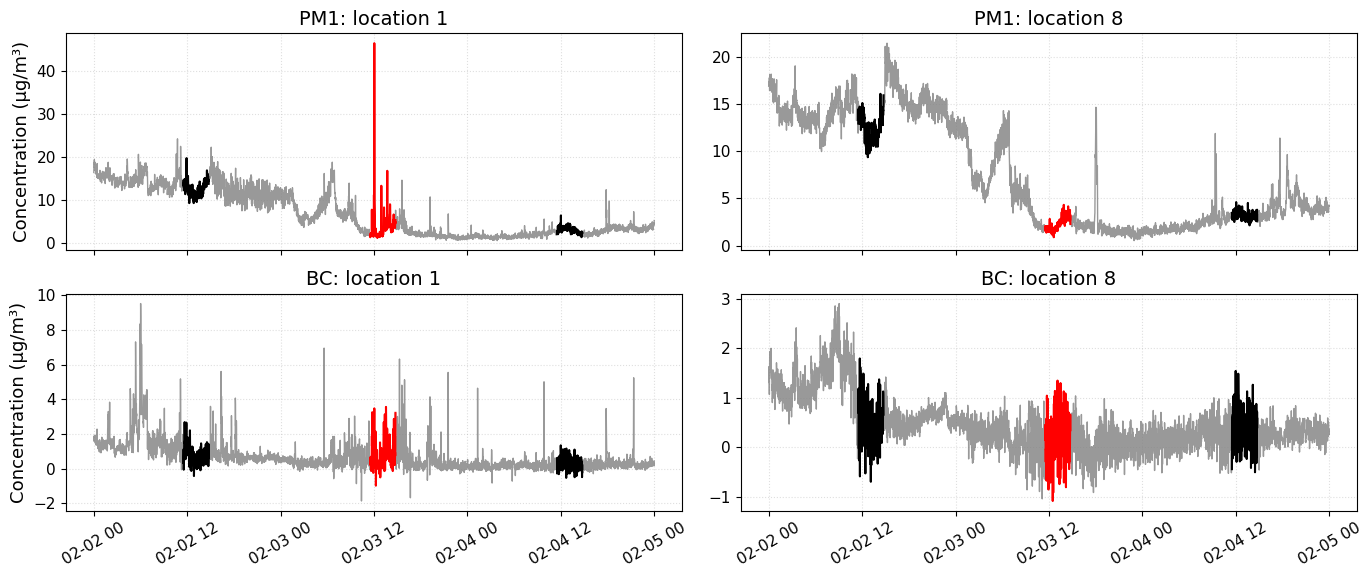

In [40]:
plot_timeseries_facets(df_subset, 
                       cols=[ys[0],ys[4]],
                       time_col='date_local',
                       ncols=2,
                       figsize_per_panel=(7, 3), # (width, height) per panel
                       sharex=True,
                       sharey=False,
                       lw=1,
                       alpha=0.8,
                       xrotation=30,
                       ylabel="Concentration (µg/m³)",
                       panel_title=[col_label[0],col_label[4]], 
                       covariate="location", 
                       label_map={1:"location 1", 8:"location 8"},
                       facet_by_group=True,
                       highlight=[(acc_start, acc_end), (win1_start, win1_end), (win3_start, win3_end)], 
                       highlight_color=["red", "black", "black"], 
                       # savepath="results/CB/figure/CB_nonegpm25mpm1_bulldozerstuck_timeseries_pm1bc_byloc.pdf"
                      )

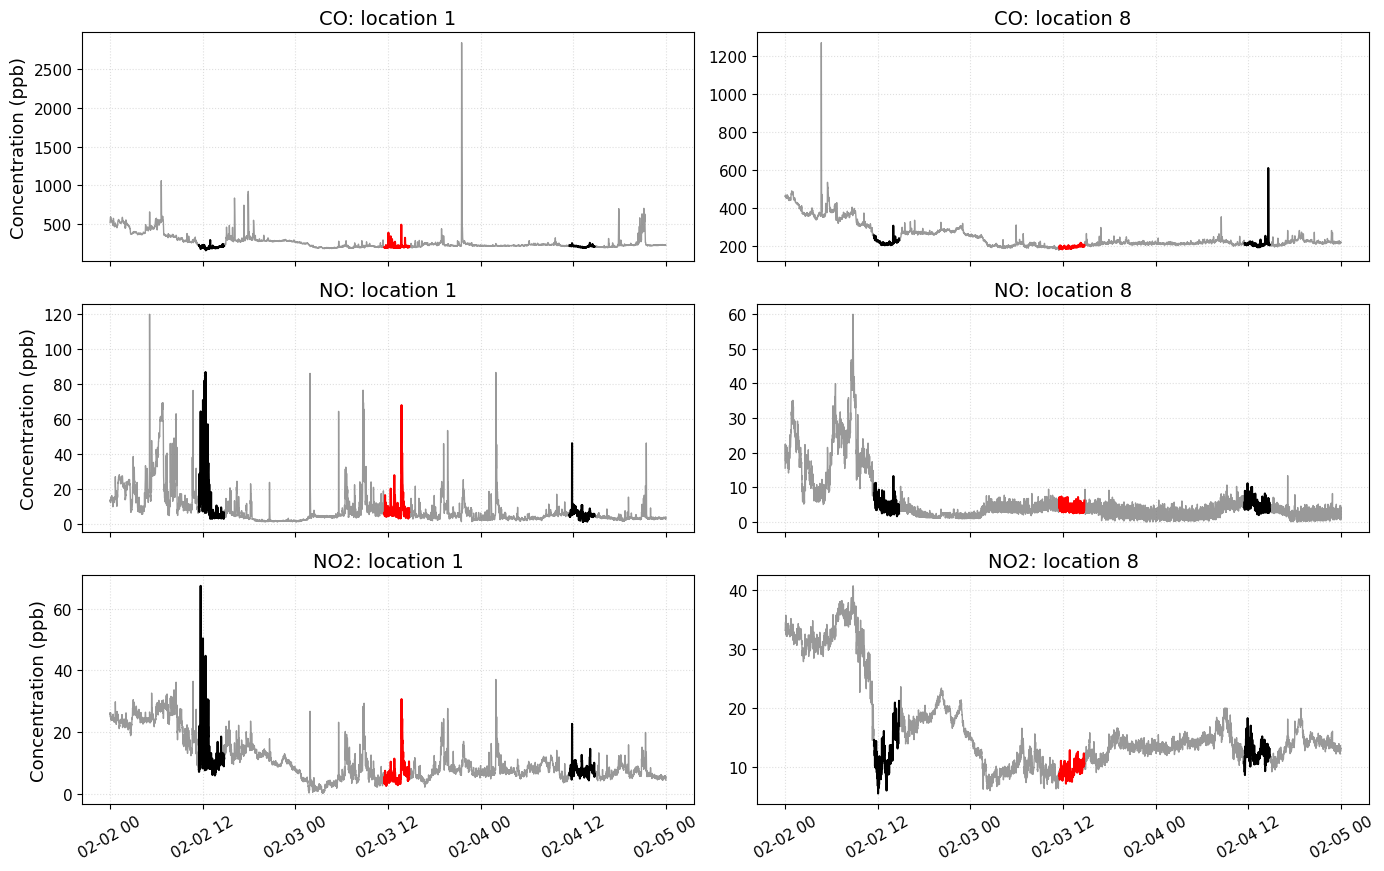

In [41]:
plot_timeseries_facets(df_subset, 
                       cols=ys[5:8],
                       time_col='date_local',
                       ncols=2,
                       figsize_per_panel=(7, 3), # (width, height) per panel
                       sharex=True,
                       sharey=False,
                       lw=1,
                       alpha=0.8,
                       xrotation=30,
                       ylabel="Concentration (ppb)",
                       panel_title=col_label[5:8], 
                       covariate="location", 
                       label_map={1:"location 1", 8:"location 8"},
                       facet_by_group=True,
                       highlight=[(acc_start, acc_end), (win1_start, win1_end), (win3_start, win3_end)], 
                       highlight_color=["red", "black", "black"], 
                       # savepath="results/CB/figure/CB_nonegpm25mpm1_bulldozerstuck_timeseries_gas_byloc.png"
                      )

## Diurnal pattern

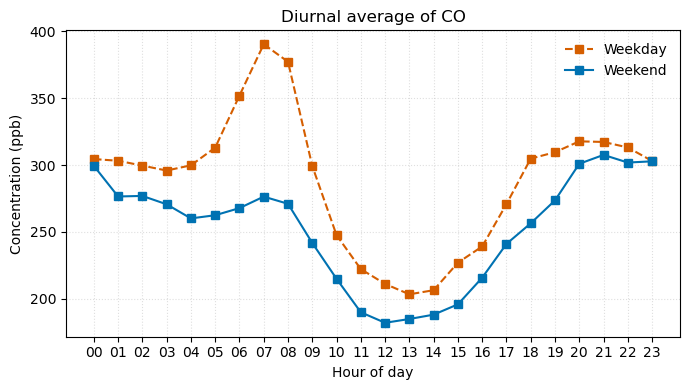

In [42]:
week = np.where(df['date_local'].dt.dayofweek >= 5, 'Weekend', 'Weekday') # Sat=5, Sun=6
plot_diurnal_W(W = df[ys], 
               columnidx=5, 
               timestamps = df['date_local'], 
               covariate=week, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of CO", 
               ylabel="Concentration (ppb)", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   # circle for urban, square for rural
               # savepath="results/CB/figure/CB_nonegpm25mpm1_K3_CO_diurnal.pdf"
)

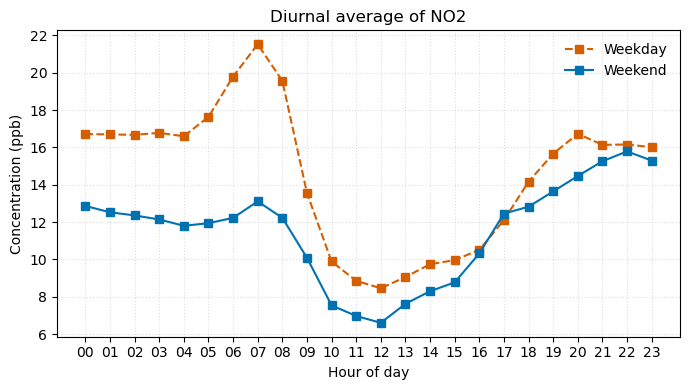

In [43]:
plot_diurnal_W(W = df[ys], 
               columnidx=7, 
               timestamps = df['date_local'], 
               covariate=week, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of NO2", 
               ylabel="Concentration (ppb)", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   # circle for urban, square for rural
               # savepath="results/CB/figure/CB_nonegpm25mpm1_K3_NO2_diurnal.pdf"
)

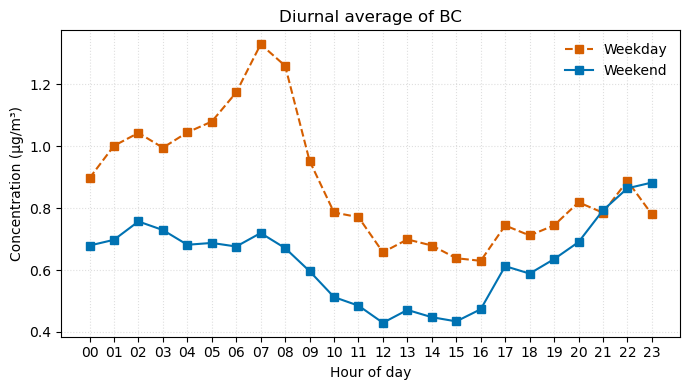

In [44]:
plot_diurnal_W(W = df[ys], 
               columnidx=4, 
               timestamps = df['date_local'], 
               covariate=week, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of BC", 
               ylabel="Concentration (µg/m³)", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   # circle for urban, square for rural
               # savepath="results/CB/figure/CB_nonegpm25mpm1_K3_traffic_source_diurnal.png"
)

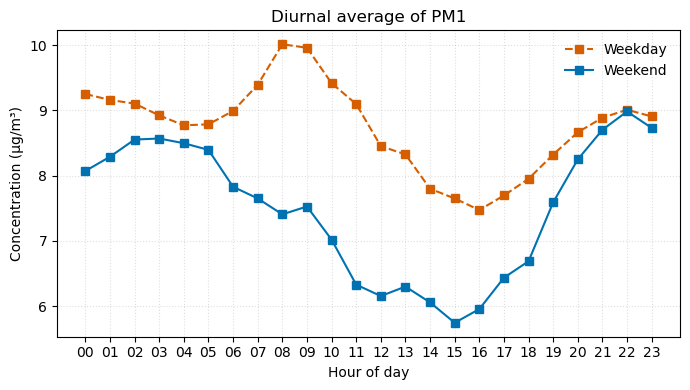

In [45]:
plot_diurnal_W(W = df[ys], 
               columnidx=0, 
               timestamps = df['date_local'], 
               covariate=week, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of PM1", 
               ylabel="Concentration (µg/m³)", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   # circle for urban, square for rural
               # savepath="results/CB/figure/CB_nonegpm25mpm1_K3_traffic_source_diurnal.png"
)

## Traffic pattern

### Curtis Bay (Pennington Avenue and Curtis Avenue between Feb 2, 2025 - Nov 2, 2025)

In [52]:
traffic_R = pyreadr.read_r('raw data/traffic_summary_curtis_bay_corr.RData')   # returns a dict-like
print(traffic_R.keys())                    # names of objects inside

odict_keys(['df_1min_corr'])


In [53]:
traffic = traffic_R['df_1min_corr']

In [54]:
traffic['date'] = pd.to_datetime(
    traffic['date'],
    utc=True,           # parse with timezone
    errors='coerce'
).dt.tz_convert('America/New_York')

In [56]:
traffic['date'].agg(["min", "max"])

min   2025-02-19 18:24:00-05:00
max   2025-11-05 18:23:00-05:00
Name: date, dtype: datetime64[ns, America/New_York]

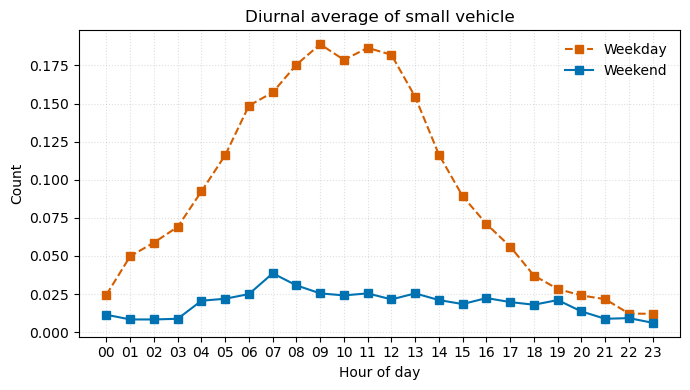

In [57]:
week_traffic = np.where(traffic['date'].dt.dayofweek >= 5, 'Weekend', 'Weekday') # Sat=5, Sun=6
plot_diurnal_W(W = traffic, 
               columnidx=1, 
               timestamps = traffic['date'], 
               covariate=week_traffic, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of small vehicle", 
               ylabel="Count", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   # circle for urban, square for rural
)

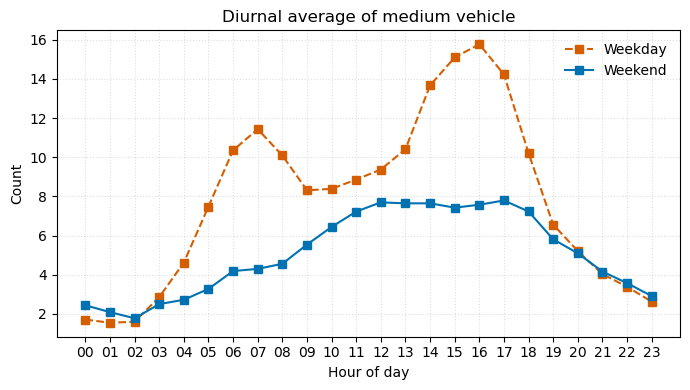

In [58]:
plot_diurnal_W(W = traffic, 
               columnidx=3, 
               timestamps = traffic['date'], 
               covariate=week_traffic, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of medium vehicle", 
               ylabel="Count", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   # circle for urban, square for rural
               # savepath="results/CB/figure/CB_traffic_medium_diurnal.pdf"
)

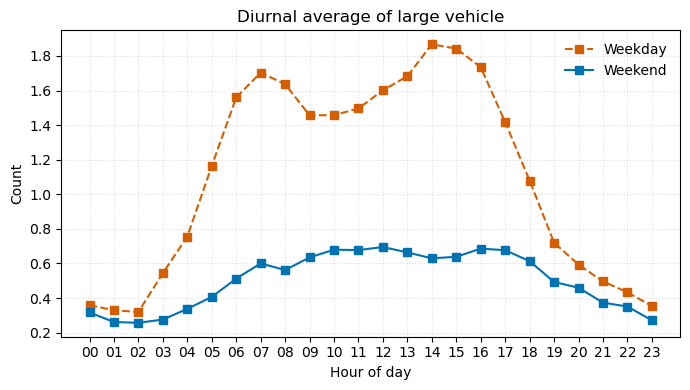

In [59]:
plot_diurnal_W(W = traffic, 
               columnidx=5, 
               timestamps = traffic['date'], 
               covariate=week_traffic, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of large vehicle", 
               ylabel="Count", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   # circle for urban, square for rural
               # savepath="results/CB/figure/CB_traffic_large_diurnal.pdf"
)